# Chapter2 PyMCについてもう少し
## 例題：ベイズ的A/Bテスト
- webサイトのCV率の評価
    - 真のCV率：$p_A$ <-この真の値はわからない。これを知りたい
- 訪問者数：$N$
- コンバージョン数：$n$
- 問題：観測された$N$と$n$から、真の$p_A$を推定したい

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

### 単純な場合
- $p_A$の事前分布：[0,1]の一様分布とする（何の情報もない）


シミュレーションで観測したCV数:88
シミュレーションで観測したCV頻度:0.058666666666666666
 [-----------------100%-----------------] 20000 of 20000 complete in 3.0 sec

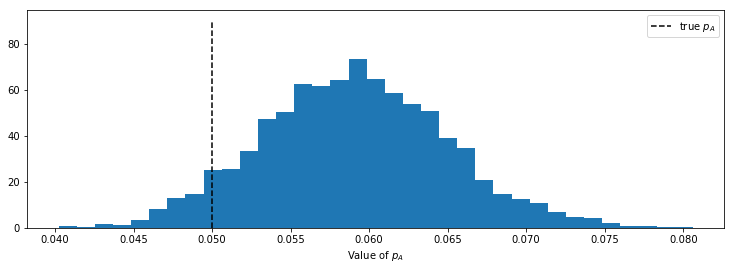

In [2]:
import pymc as pm

# 事前分布
p = pm.Uniform("p", lower=0, upper=1)


# *** 人工データをシミュレーションする

# 真のp_A(本当は未知の値)
p_true = 0.05
# 訪問者数の設定
N = 1500

# 事象はベルヌーイ分布からサンプルされると仮定する
## シミュレーションで観測データを生成する
## 実際は、これはCVしたかしないかの実際の観測データ列になる（列数は当然、訪問者数のN）
occurrences = pm.rbernoulli(p_true, N)
print("シミュレーションで観測したCV数:{}".format(occurrences.sum()))
print("シミュレーションで観測したCV頻度:{}".format(occurrences.mean()))

## p_Aの推論をする
### 観測データ. データはベルヌーイ分布に従うとする 
### 観測データなので、observed=Trueで観測済みとする
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)
### 推論ステップ
mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

## 事後分布のプロット
figsize(12.5, 4)

plt.vlines(p_true, 0, 90, linestyles="--", label="true $p_A$")
plt.hist(mcmc.trace("p")[:], bins=35, histtype="stepfilled", normed=True)
plt.xlabel("Value of $p_A$")
plt.legend()

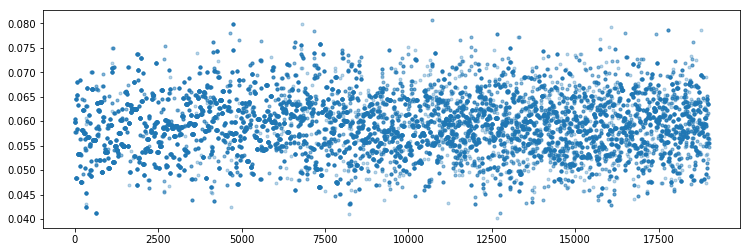

In [3]:
plt.plot(mcmc.trace("p")[:], '.', alpha=0.3)

### AとBを一緒に
- 本当に知りたいのは、サイトAとBでどっちが効果があるのかということ（A/Bテストなので）
- サイトBのCV率を$p_B$とする
- $p_A$と$p_B$の差を評価するので、$p_A - p_B$を推論したい

In [4]:
figsize(12, 4)

# 真のCV率（本当は未知）
true_p_A = 0.05
true_p_B = 0.04

# 訪問者数の設定（サンプルサイズ） → サンプルサイズが異なるのは現実ではよくあること
N_A = 1500
N_B = 750

# 観測データを作る
observation_A = pm.rbernoulli(true_p_A, N_A)
observation_B = pm.rbernoulli(true_p_B, N_B)
print(observation_A.mean())
print(observation_B.mean())

0.0386666666667
0.0413333333333


In [5]:
# PnMCモデルの設定

# p_A, p_Bの事前分布
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

# AとBの差を表す変数（これも予測対象で、p_Aとp_Bがわかれば決定的）
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# 観測データ
obs_A = pm.Bernoulli("obs_A", p_A, value=observation_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observation_B, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 5.9 sec

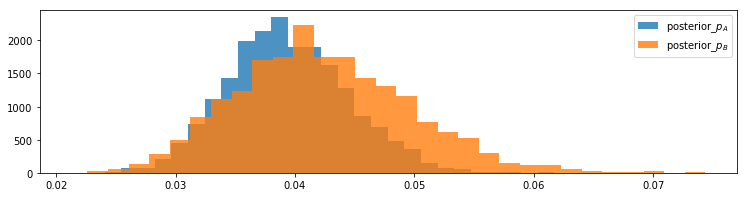

In [6]:
p_A_sample = mcmc.trace("p_A")[:]
p_B_sample = mcmc.trace("p_B")[:]
delta_sample = mcmc.trace("delta")[:]

figsize(12.5, 3)

plt.hist(p_A_sample, bins=30, alpha=0.8, label="posterior_$p_A$")
plt.hist(p_B_sample, bins=30, alpha=0.8, label="posterior_$p_B$")

plt.legend()


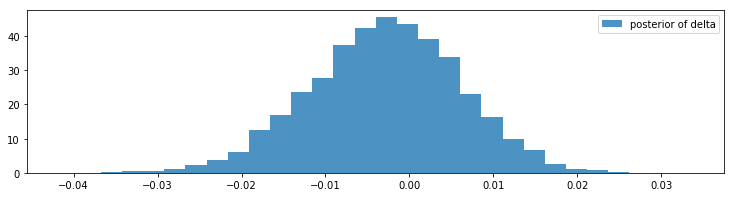

In [7]:
plt.hist(delta_sample, bins=30, alpha=0.8, label="posterior of delta", normed=True)
plt.legend()

In [8]:
print("サイトAがサイトBよりもCV率が悪い確率 : %.3f" % (delta_sample<0.).mean())
print("サイトAがサイトBよりもCV率が良い確率 : %.3f" % (delta_sample>0.).mean())

サイトAがサイトBよりもCV率が悪い確率 : 0.622
サイトAがサイトBよりもCV率が良い確率 : 0.378
